<a href="https://colab.research.google.com/github/rmahesh6386/Tata-Motors-Project-/blob/main/TATA_Motors_Stock_market_Forecasting_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

plt.style.use("ggplot")

%matplotlib inline

In [122]:
plt.rcParams["figure.figsize"] = (12, 6)

In [123]:
# For reading stock data from yahoo
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

# For time stamps
from datetime import datetime

# For division
from __future__ import division

In [124]:
#stock Company for analytics
stock = ['TATAMOTORS.NS']
data_source = 'yahoo' 

# set up Start and End time for data grab
dt = datetime.now()
end = datetime(dt.year,dt.month,dt.day)
start = datetime(end.year-10,end.month,end.day)

# Set DataFrame as the Stock Ticker
df = pdr.get_data_yahoo(stock,start,end)

[*********************100%***********************]  1 of 1 completed


In [125]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-08-03,218.654709,219.644104,213.856171,218.605240,216.115479,7327872
2012-08-06,224.096344,227.509735,223.700592,226.619278,224.038239,7596745
2012-08-07,228.894867,236.958389,228.647522,236.265808,233.574890,12277598
2012-08-08,237.601486,243.191528,237.156265,238.937164,236.215820,15104047
2012-08-09,239.827606,243.389404,229.191696,236.760513,234.063965,29687040
...,...,...,...,...,...,...
2022-07-27,441.149994,445.000000,436.100006,444.049988,444.049988,10081023
2022-07-28,440.250000,449.250000,427.399994,442.250000,442.250000,36380444
2022-07-29,445.149994,452.700012,445.149994,449.600006,449.600006,16004096


In [126]:
df.index

DatetimeIndex(['2012-08-03', '2012-08-06', '2012-08-07', '2012-08-08',
               '2012-08-09', '2012-08-10', '2012-08-13', '2012-08-14',
               '2012-08-16', '2012-08-17',
               ...
               '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-25',
               '2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29',
               '2022-08-01', '2022-08-02'],
              dtype='datetime64[ns]', name='Date', length=2463, freq=None)

Check whether you have duplicate data on by date

In [127]:
df[df.index.duplicated(keep = False)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


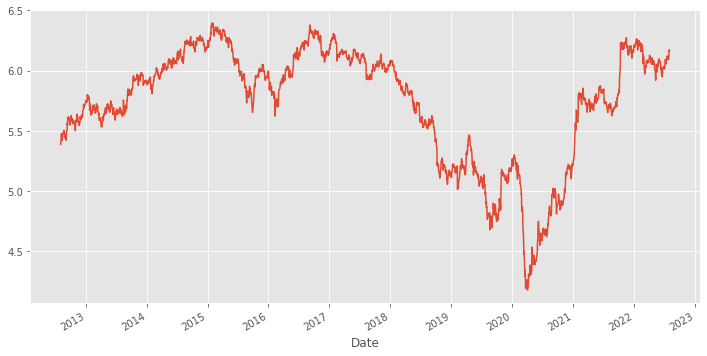

In [128]:
y = np.log(df["Close"])
y.plot()

In [129]:
y.index

DatetimeIndex(['2012-08-03', '2012-08-06', '2012-08-07', '2012-08-08',
               '2012-08-09', '2012-08-10', '2012-08-13', '2012-08-14',
               '2012-08-16', '2012-08-17',
               ...
               '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-25',
               '2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29',
               '2022-08-01', '2022-08-02'],
              dtype='datetime64[ns]', name='Date', length=2463, freq=None)

Calculate rolling mean, exponentially weighted mean

In [130]:
period = 100
y_rolling = pd.DataFrame(dict(actual = y, 
                              rolling_mean = y.rolling(period).mean(), 
                              ewm = y.ewm(span = period).mean()
                             ))
y_rolling.tail()

,actual,rolling_mean,ewm
Date,,,
2022-07-27,6.095937,6.052111,6.063704
2022-07-28,6.091875,6.052693,6.064262
2022-07-29,6.108358,6.054013,6.065135
2022-08-01,6.172118,6.056028,6.067253
2022-08-02,6.165943,6.057627,6.069208


In [131]:
rolling_dropped = y_rolling.dropna()
print("rmse over rolling mean: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped.rolling_mean) ** 0.5)
print("rmse over ewma: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped["ewm"]) ** 0.5)

rmse over rolling mean:  0.18574680952457842
rmse over ewma:  0.15787534397721456


By visual inspection, we see the time series is not stationary. Let we will see a more formal way of testing using Dickey Fullter Test.

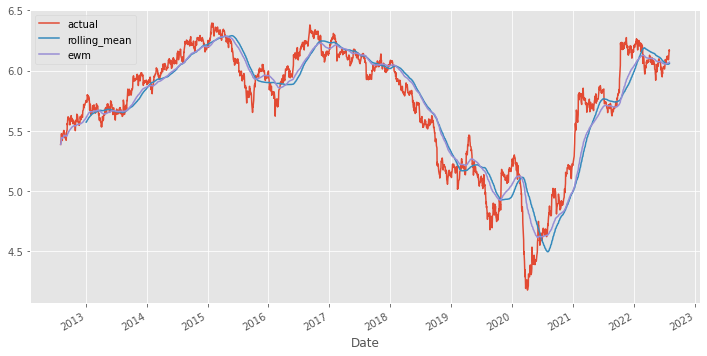

In [132]:
y_rolling.plot()

Formal of way of test for stationarity. Since the p-value of Augmented Dickey Fullter test is > 0.05, we can say that there is not sufficient proof that the time series is stationary. Loosely speaking, it is non-stationary. We need further transformation to make data stationary. Populary method for making data stationary will be to take "difference". Taking difference by lag one, we see the p-val for Dickey Fuller test is < 0.05. So we conclude, diff 1 has made the data stationary.

In [133]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(y.dropna())

ADF Statistic: -1.348580
p-value: 0.606665
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Non-stationary


In [134]:
diff = pd.DataFrame({"actual": y, "diff1": y.diff(3)}).head(10)
diff["diff2"] = diff.diff1.diff(1)
diff

,actual,diff1,diff2
Date,,,
2012-08-03,5.387268,NaN,NaN
2012-08-06,5.423271,NaN,NaN
2012-08-07,5.464957,NaN,NaN
2012-08-08,5.476201,0.088933,NaN
2012-08-09,5.467049,0.043778,-0.045155
2012-08-10,5.435853,-0.029105,-0.072882
2012-08-13,5.419773,-0.056428,-0.027323
2012-08-14,5.448917,-0.018133,0.038295
2012-08-16,5.450830,0.014977,0.033109


In [135]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(y.diff(periods=1).dropna())

ADF Statistic: -48.578472
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


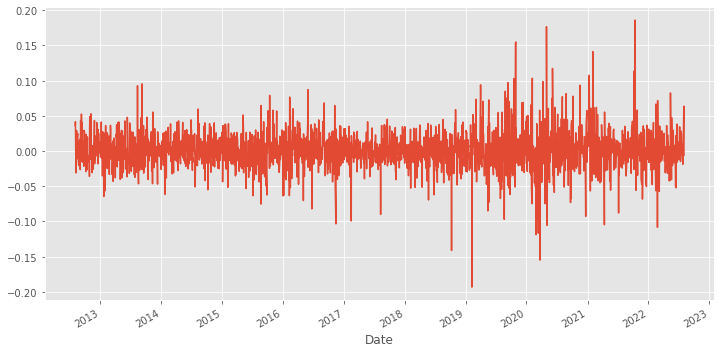

In [136]:
y.diff(periods=1).plot()

Use pandas's auto correlation plot. Here is a nice explanation of the autocorrelation plot

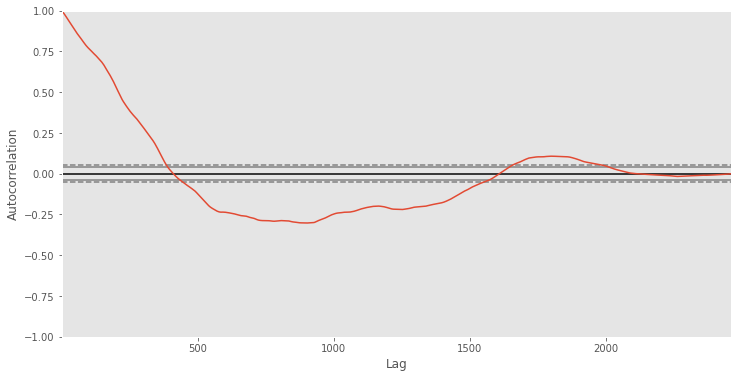

In [137]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y)

In [138]:
y = y.dropna()

In [139]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(y, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10819.685, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10818.762, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10818.741, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10821.343, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10817.084, Time=1.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.703 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 2463
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5411.672
Date:                Wed, 03 Aug 2022   AIC                         -10821.343
Time:                        08:21:00   BIC                         -10815.535
Sample:                             0   HQIC                        -10819.233
                               - 2463                             

                  0
count  2.462000e+03
mean   5.700273e-10
std    2.686626e-02
min   -1.936914e-01
25%   -1.355490e-02
50%   -3.162770e-04
75%    1.317236e-02
max    1.857210e-01


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


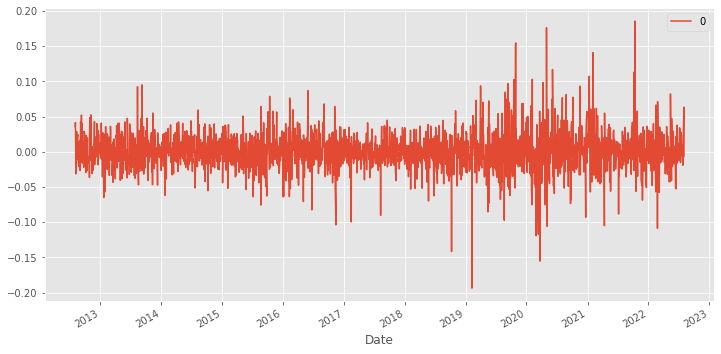

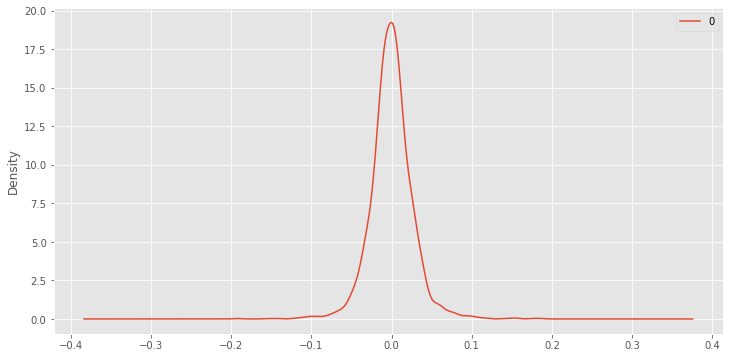

In [140]:
from statsmodels.tsa.arima_model import ARIMA

p=0
d=1
q=0

# fit model
model = ARIMA(y, order=(p, d, q)) 
model_fit = model.fit(disp=0)
#print(model_fit.summary())

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [141]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2462
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5411.842
Method:                           css   S.D. of innovations              0.027
Date:                Wed, 03 Aug 2022   AIC                         -10819.685
Time:                        08:21:00   BIC                         -10808.067
Sample:                             1   HQIC                        -10815.464
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.584      0.559      -0.001       0.001
==============================================================================
"""

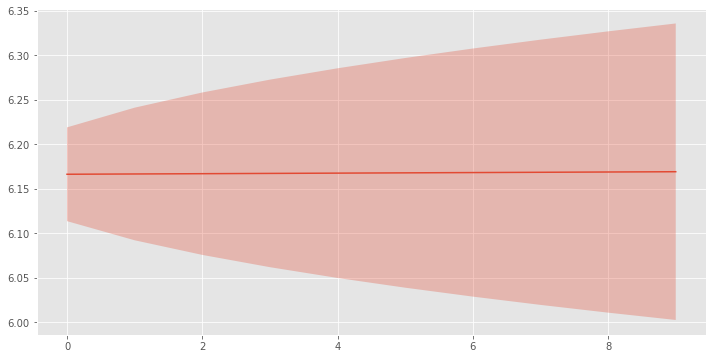

In [142]:
model = ARIMA(y.values, order=(p, d, q))
model_fit = model.fit(disp=0)
predictions, error, conf_interval = model_fit.forecast(10)
plt.plot(predictions)
plt.fill_between(range(len(predictions)), conf_interval[:,0], conf_interval[:,1], alpha = 0.3)

In [143]:
predictions[:10]

array([6.1662592 , 6.16657548, 6.16689176, 6.16720803, 6.16752431,
       6.16784059, 6.16815687, 6.16847314, 6.16878942, 6.1691057 ])

In [144]:
from sklearn.metrics import mean_squared_error

x = y.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, actual=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

predicted=4.820356, actual=4.804431
predicted=4.804093, actual=4.803611
predicted=4.803273, actual=4.794964
predicted=4.794621, actual=4.798679
predicted=4.798338, actual=4.794136
predicted=4.793793, actual=4.819071
predicted=4.818743, actual=4.722064
predicted=4.721679, actual=4.679350
predicted=4.678941, actual=4.709981
predicted=4.709590, actual=4.705468
predicted=4.705075, actual=4.790404
predicted=4.790060, actual=4.756603
predicted=4.756239, actual=4.738827
predicted=4.738453, actual=4.759607
predicted=4.759245, actual=4.724286
predicted=4.723904, actual=4.695925
predicted=4.695527, actual=4.771108
predicted=4.770754, actual=4.797855
predicted=4.797516, actual=4.803201
predicted=4.802866, actual=4.900448
predicted=4.900169, actual=4.851640
predicted=4.851332, actual=4.864067
predicted=4.863767, actual=4.856707
predicted=4.856403, actual=4.804021
predicted=4.803687, actual=4.801970
predicted=4.801635, actual=4.821893
predicted=4.821570, actual=4.892227
predicted=4.891944, actual=4

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.132121, actual=5.112590
predicted=5.112437, actual=5.084505
predicted=5.084337, actual=5.078294
predicted=5.078122, actual=5.073297
predicted=5.073123, actual=5.086361
predicted=5.086194, actual=5.155313
predicted=5.155184, actual=5.174453
predicted=5.174336, actual=5.164500
predicted=5.164377, actual=5.194067
predicted=5.193960, actual=5.163642
predicted=5.163519, actual=5.188223
predicted=5.188113, actual=5.170200
predicted=5.170080, actual=5.170768
predicted=5.170649, actual=5.167639
predicted=5.167518, actual=5.162498
predicted=5.162374, actual=5.171336
predicted=5.171217, actual=5.213304
predicted=5.213208, actual=5.221166
predicted=5.221075, actual=5.217378
predicted=5.217285, actual=5.266569
predicted=5.266502, actual=5.252797
predicted=5.252723, actual=5.223863
predicted=5.223773, actual=5.218733
predicted=5.218640, actual=5.207024
predicted=5.206925, actual=5.257495
predicted=5.257424, actual=5.279899
predicted=5.279840, actual=5.279389
predicted=5.279330, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.130352, actual=5.085124
predicted=5.084961, actual=5.062911
predicted=5.062736, actual=5.065755
predicted=5.065581, actual=5.014959
predicted=5.014759, actual=5.009968
predicted=5.009765, actual=4.973625
predicted=4.973403, actual=4.978456
predicted=4.978236, actual=4.859425
predicted=4.859141, actual=4.831509
predicted=4.831210, actual=4.870223
predicted=4.869945, actual=4.837868
predicted=4.837573, actual=4.834296
predicted=4.833999, actual=4.737951
predicted=4.737603, actual=4.660605
predicted=4.660215, actual=4.594109
predicted=4.593684, actual=4.477337
predicted=4.476849, actual=4.497028
predicted=4.496551, actual=4.418238
predicted=4.417720, actual=4.356068
predicted=4.355516, actual=4.324133
predicted=4.323564, actual=4.289774
predicted=4.289188, actual=4.347694
predicted=4.347139, actual=4.192680
predicted=4.192043, actual=4.227563
predicted=4.226945, actual=4.252060
predicted=4.251455, actual=4.259859
predicted=4.259258, actual=4.258446
predicted=4.257844, actual=4

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4.394545, actual=4.455509
predicted=4.455020, actual=4.456670
predicted=4.456182, actual=4.468204
predicted=4.467722, actual=4.428433
predicted=4.427930, actual=4.434975
predicted=4.434476, actual=4.390119
predicted=4.389596, actual=4.404277
predicted=4.403763, actual=4.424248
predicted=4.423744, actual=4.432007
predicted=4.431507, actual=4.416428
predicted=4.415921, actual=4.420045
predicted=4.419539, actual=4.437343
predicted=4.436847, actual=4.465908
predicted=4.465427, actual=4.465908
predicted=4.465427, actual=4.494797
predicted=4.494332, actual=4.569543
predicted=4.569117, actual=4.592591
predicted=4.592178, actual=4.590057
predicted=4.589642, actual=4.707275
predicted=4.706922, actual=4.748838
predicted=4.748506, actual=4.713576
predicted=4.713226, actual=4.713127
predicted=4.712777, actual=4.664853
predicted=4.664478, actual=4.656813
predicted=4.656434, actual=4.610158
predicted=4.609755, actual=4.551242
predicted=4.550808, actual=4.558079
predicted=4.557649, actual=4

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4.667308, actual=4.661078
predicted=4.660707, actual=4.641020
predicted=4.640639, actual=4.650621
predicted=4.650246, actual=4.727830
predicted=4.727494, actual=4.713576
predicted=4.713233, actual=4.748404
predicted=4.748079, actual=4.760463
predicted=4.760144, actual=4.779963
predicted=4.779655, actual=4.819071
predicted=4.818782, actual=4.806477
predicted=4.806182, actual=4.831110
predicted=4.830827, actual=4.876342
predicted=4.876082, actual=4.825109
predicted=4.824824, actual=4.816646
predicted=4.816357, actual=4.833102
predicted=4.832822, actual=4.829513
predicted=4.829231, actual=4.801559
predicted=4.801263, actual=4.794964
predicted=4.794664, actual=4.797442
predicted=4.797144, actual=4.844974
predicted=4.844700, actual=4.926529
predicted=4.926296, actual=4.971548
predicted=4.971338, actual=4.961445
predicted=4.961230, actual=4.964242
predicted=4.964029, actual=4.968423
predicted=4.968212, actual=5.012633
predicted=5.012445, actual=5.022893
predicted=5.022710, actual=4

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.674827, actual=5.650558
predicted=5.650677, actual=5.679831
predicted=5.679964, actual=5.683410
predicted=5.683544, actual=5.693227
predicted=5.693365, actual=5.716040
predicted=5.716189, actual=5.697597
predicted=5.697737, actual=5.702782
predicted=5.702924, actual=5.703949
predicted=5.704092, actual=5.697429
predicted=5.697569, actual=5.684260
predicted=5.684394, actual=5.688500
predicted=5.688635, actual=5.723585
predicted=5.723737, actual=5.727662
predicted=5.727815, actual=5.716040
predicted=5.716188, actual=5.696086
predicted=5.696225, actual=5.681366
predicted=5.681499, actual=5.645800
predicted=5.645916, actual=5.623837
predicted=5.623943, actual=5.634075
predicted=5.634186, actual=5.650382
predicted=5.650500, actual=5.650030
predicted=5.650148, actual=5.655117
predicted=5.655237, actual=5.676583
predicted=5.676712, actual=5.660527
predicted=5.660649, actual=5.687822
predicted=5.687957, actual=5.680684
predicted=5.680816, actual=5.688838
predicted=5.688973, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.154128, actual=6.157720
predicted=6.158054, actual=6.147613
predicted=6.147942, actual=6.155177
predicted=6.155509, actual=6.174203
predicted=6.174543, actual=6.165418
predicted=6.165754, actual=6.153583
predicted=6.153914, actual=6.178774
predicted=6.179115, actual=6.209797
predicted=6.210152, actual=6.193589
predicted=6.193937, actual=6.193895
predicted=6.194243, actual=6.192056
predicted=6.192403, actual=6.195629
predicted=6.195977, actual=6.221981
predicted=6.222340, actual=6.217205
predicted=6.217562, actual=6.229004
predicted=6.229366, actual=6.238227
predicted=6.238593, actual=6.234215
predicted=6.234579, actual=6.263398
predicted=6.263775, actual=6.235978
predicted=6.236343, actual=6.255462
predicted=6.255835, actual=6.245525
predicted=6.245894, actual=6.218301
predicted=6.218658, actual=6.170552
predicted=6.170888, actual=6.195527
predicted=6.195874, actual=6.203345
predicted=6.203695, actual=6.209193
predicted=6.209545, actual=6.249493
predicted=6.249862, actual=6

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



predicted=6.022981, actual=6.012370
predicted=6.012626, actual=6.021023
predicted=6.021283, actual=6.031526
predicted=6.031790, actual=6.065760
predicted=6.066038, actual=6.090291
predicted=6.090579, actual=6.080048
predicted=6.080331, actual=6.065063
predicted=6.065340, actual=6.057018
predicted=6.057292, actual=6.059240
predicted=6.059514, actual=6.087229
predicted=6.087515, actual=6.111246
predicted=6.111541, actual=6.107134
predicted=6.107428, actual=6.116885
predicted=6.117182, actual=6.119968
predicted=6.120266, actual=6.120078
predicted=6.120376, actual=6.108247
predicted=6.108541, actual=6.089385
predicted=6.089671, actual=6.095937
predicted=6.096225, actual=6.091875
predicted=6.092162, actual=6.108358
predicted=6.108651, actual=6.172118
predicted=6.172437, actual=6.165943
Test RMSE: 0.034


In [145]:
print('Test RMSE: %.3f' % np.sqrt(error))

Test RMSE: 0.034


In [146]:
result = pd.DataFrame(np.exp(y))[train_size:]
result.columns = ["actual"]
result["prediction"] = np.exp(predictions)
result

,actual,prediction
Date,,
2019-08-09,122.050003,124.009218
2019-08-13,121.949997,122.008748
2019-08-14,120.900002,121.908742
2019-08-16,121.349998,120.858520
2019-08-19,120.800003,121.308647
...,...,...
2022-07-27,444.049988,441.276075
2022-07-28,442.250000,444.178031
2022-07-29,449.600006,442.376741


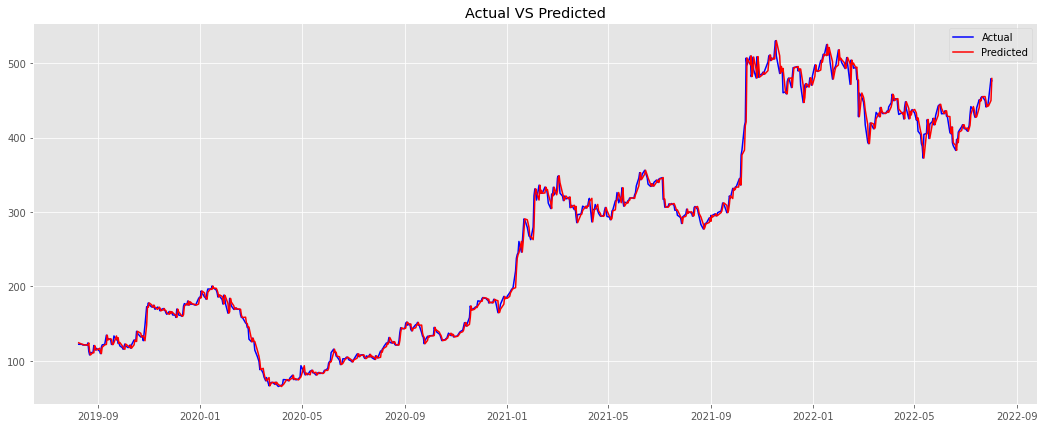

In [147]:
plt.figure(figsize=(18,7))
fig=plt.figure(1)
plt.plot(result["actual"],color='blue',label='Actual')
plt.plot(result["prediction"], color='red', label='Predicted')
plt.legend(loc = 'best')
plt.title('Actual VS Predicted')
plt.show(block = False)

In [148]:
model = ARIMA(y, order=(0,1,0))
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [149]:
predictions=pd.Series(model_fit.fittedvalues, copy=True)
print(predictions.head())

Date
2012-08-06    0.000316
2012-08-07    0.000316
2012-08-08    0.000316
2012-08-09    0.000316
2012-08-10    0.000316
dtype: float64


In [150]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Date
2012-08-06    0.000316
2012-08-07    0.000633
2012-08-08    0.000949
2012-08-09    0.001265
2012-08-10    0.001581
dtype: float64


In [151]:
predictions_log=pd.Series(y, index=y.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log

Date
2012-08-03    5.387268
2012-08-06    5.423588
2012-08-07    5.465590
2012-08-08    5.477149
2012-08-09    5.468314
                ...   
2022-07-27    6.873346
2022-07-28    6.869600
2022-07-29    6.886400
2022-08-01    6.950476
2022-08-02    6.944617
Length: 2463, dtype: float64

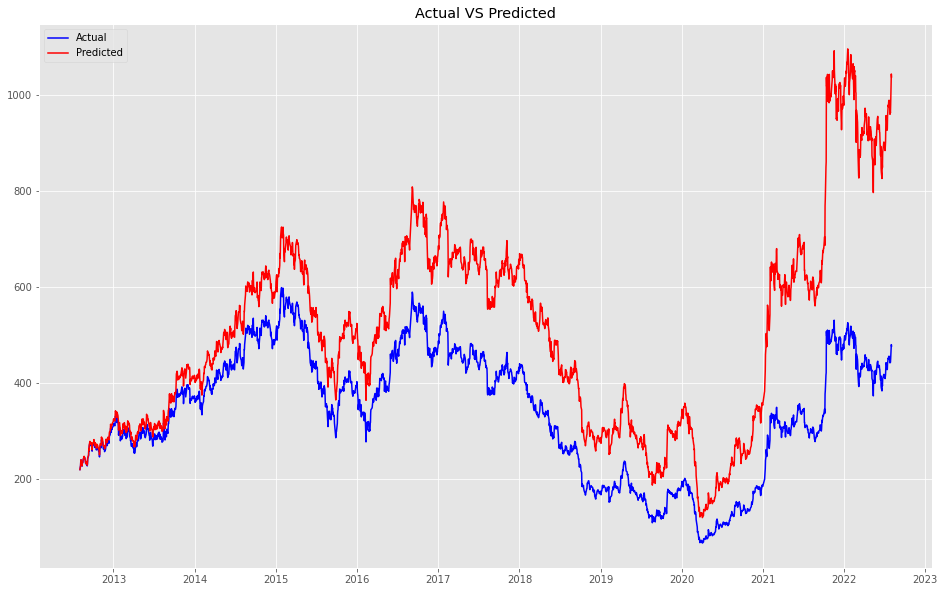

In [152]:
predictions_ARIMA=np.exp(predictions_log)
plt.figure(figsize=(16,10))
plt.plot(df["Close"],color='blue',label='Actual')
plt.plot(predictions_ARIMA,color='red', label='Predicted')
plt.legend(loc = 'best')
plt.title('Actual VS Predicted')
plt.show(block = False)

In [153]:
forecast=model_fit.forecast(steps=1)[0]
np.exp(forecast)

array([476.40065074])

In [154]:
#stock Company for analytics
stock = ['TATAMOTORS.NS']
data_source = 'yahoo' 

# set up Start and End time for data grab
end1 = datetime.now()
start1 = datetime.now()

# Set DataFrame as the Stock Ticker
df = pdr.get_data_yahoo(stock,start1,end1)

[*********************100%***********************]  1 of 1 completed


In [155]:
df['Close']

Date
2022-08-03    460.450012
Name: Close, dtype: float64

In [156]:
result = pd.DataFrame(df['Close'])
result.columns = ["actual"]
result["forecast"] = np.exp(forecast)
result

,actual,forecast
Date,,
2022-08-03,460.450012,476.400651


In [157]:
error = mean_squared_error(result["actual"] , result["forecast"] )
print('Forecast RMSE: %.3f' % np.sqrt(error))

Forecast RMSE: 15.951
